Twitter Sentiment Classification
*   Below we load the packages needed and also the data from google drive
*   Once we have loaded the data we do some basic EDA






In [ ]:
%%capture

!pip install torch
!pip install torchtext
!pip install transformers   # for our application example in the end
!pip install numpy

#!pip install torchdata
!pip install datasets

!pip install -U sentence-transformers
!pip install portalocker

In [37]:
import torch
#torch.utils.data.datapipes.utils.common.DILL_AVAILABLE = torch.utils._import_utils.dill_available() #workaround
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import numpy as np
import random

from transformers import AutoTokenizer, GPT2Model, GPT2ForSequenceClassification

from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
# # Mount Google Drive
drive.mount('/content/drive')

# # Path to your file
file_path = '/content/drive/My Drive/twitter_training.csv'

file_path2 = '/content/drive/My Drive/twitter_validation.csv'
column_names = ['id', 'entity', 'label', 'text']
# # Load the data into a DataFrame
df = pd.read_csv(file_path,header=None, names=column_names)

df.head()

# # Load the data into a DataFrame
df2 = pd.read_csv(file_path2,header=None, names=column_names)

df2.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,entity,label,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


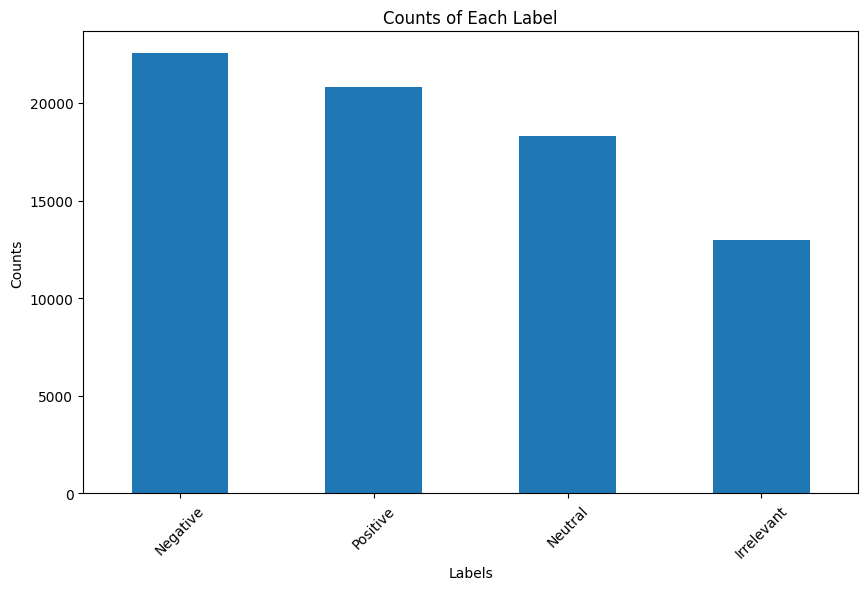

In [39]:
# Assuming your dataframe is named df
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')

plt.title('Counts of Each Label')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

Below we label encode the sentiments of the text to convert from negative, positive, neutral, irrelevant to 0,1,2,3

In [40]:
#label encode the sentiment column ('label')

# Assuming your dataframe is named df and the column you want to encode is 'column_name'
label_encoder = LabelEncoder()

# Apply label encoding to the specified column
df['label'] = label_encoder.fit_transform(df['label'])
df2['label'] = label_encoder.fit_transform(df2['label'])

# If you want to overwrite the original column, you can do this:
# df['column_name'] = label_encoder.fit_transform(df['column_name'])

# Show the first few rows to verify
print(df.head())

# Display the mapping of encoded values to original labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Encoded Values and their Equivalents:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

     id       entity  label                                               text
0  2401  Borderlands      3  im getting on borderlands and i will murder yo...
1  2401  Borderlands      3  I am coming to the borders and I will kill you...
2  2401  Borderlands      3  im getting on borderlands and i will kill you ...
3  2401  Borderlands      3  im coming on borderlands and i will murder you...
4  2401  Borderlands      3  im getting on borderlands 2 and i will murder ...
Label Encoded Values and their Equivalents:
Irrelevant: 0
Negative: 1
Neutral: 2
Positive: 3


In [41]:
df = df[['text', 'label']]
df2 = df2[['text', 'label']]
# Convert dataframe to dictionary (default: columns as keys)
df = df.to_dict(orient='records')
df2 = df2.to_dict(orient='records')
df[:5]

[{'text': 'im getting on borderlands and i will murder you all ,', 'label': 3},
 {'text': 'I am coming to the borders and I will kill you all,', 'label': 3},
 {'text': 'im getting on borderlands and i will kill you all,', 'label': 3},
 {'text': 'im coming on borderlands and i will murder you all,', 'label': 3},
 {'text': 'im getting on borderlands 2 and i will murder you me all,',
  'label': 3}]

Irrelevant: 0
Negative: 1
Neutral: 2
Positive: 3

Below we create a temporary dataset that will house our data - the counts of each sentiment are displayed when the function is called

In [42]:
def create_temp_set(base_data, num_examples=1000000000):
    #counts for each class
    num_positive = 0
    num_negative = 0
    num_neutral = 0
    num_irrelevant=0
    #lists to store data temp
    temp_data = []
    out_data = []

    #iterate through all imdb dataset
    for example_num, example in enumerate(base_data):
      #add each example to temp_data
      temp_data.append(example)
    #shuffle temp data
    random.shuffle(temp_data)

    #iterate through the entire list of data
    for example_num, example in enumerate(temp_data):
      #limit the new list to a predefined length
      if num_examples != -1 and example_num > num_examples:
        break
      #each example is comprised of a 'text' and a 'label' - add to the count of classes and print it when done
      if example['label'] == 1:
        num_negative += 1
      elif example['label'] == 3:
        num_positive += 1
      elif example['label'] == 2:
        num_neutral += 1
      else:
        num_irrelevant += 1

      out_data.append(example)


    print('positive: ', num_positive)
    print('negative: ', num_negative)
    print('irrelevant: ',num_irrelevant)
    print('neutral: ', num_neutral)

    #the output is a list of dictionaries
    return out_data

# There appears to be an issue with the IMDB data. Let's which of the two sets has the full data and pick that one.
data_train = create_temp_set(df)
data_test = create_temp_set(df2)

#consolidate irrelevenat netural and negative / drop anything that is not positive or negative

positive:  20832
negative:  22542
irrelevant:  12990
neutral:  18318
positive:  277
negative:  266
irrelevant:  172
neutral:  285


In [44]:
#shorten data for practical use
data_train = data_train[:1000]
data_test = data_test[:1000]

In [45]:
print('this is the number of texts in the train set: ', len(data_train))
print('this is the number of texts in the test set: ', len(data_test))

this is the number of texts in the train set:  1000
this is the number of texts in the test set:  1000


In [46]:
type(data_train[1]['label'])

int

Next we instantiate the gpt_2 tokenizer and store it on our device. We also text an example to make sure the tokenizer is working.

In [47]:
gpt_2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt_2_model = GPT2Model.from_pretrained("gpt2").to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [49]:
gpt_2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenized_input_2 = gpt_2_tokenizer(['This is great', 'Marvelously done by you!'],
                              return_tensors="pt",
                              max_length=7,
                              truncation=True,
                              padding='max_length').to(device)
tokenized_input_2

{'input_ids': tensor([[ 1212,   318,  1049, 50257, 50257, 50257, 50257],
        [38864,  3481,  1760,   416,   345,     0, 50257]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0]], device='cuda:0')}

Next we take a look at the gpt 2 model architecture. Note that it is a transformer with encoding blocks that use multi-headed attention in combination with convolutional and drop out layers. There is also an MLP layer.

In [50]:
#show architecture

pre_train_param_values = []

print(f"Model structure: {gpt_2_model}\n\n")

layer_count = 0

for param in gpt_2_model.parameters():
    param.requires_grad = True   # make sure that the gpt2 model layers can be retrained (try also without...)

num_layer_names_shown = 100000


for layer_num, (name, param) in enumerate(gpt_2_model.named_parameters()):
  pre_train_param_values.append(param.cpu().detach().numpy())

pre_train_param_values[15][:15]

Model structure: GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)




array([-0.00362932, -0.00622698, -0.00362774, -0.0011091 , -0.01039783,
       -0.00634792, -0.02703804,  0.04477038, -0.01744087, -0.00305082,
       -0.00317421, -0.00448913, -0.00828817, -0.01425266, -0.01139623],
      dtype=float32)

After examining the model we will be using we create the dataset class and instantiate two instances of the class for train and test data.

In [51]:
# convert to strings
for item in data_train:
    if 'text' in item:
        item['text'] = str(item['text'])

for item in data_test:
    if 'text' in item:
        item['text'] = str(item['text'])


Important note on the gpt_2_tokenizer... -> by default the padding token is OOV so running the model to create a hidden state context vector that has encoded all of the prior tokens will not work unless you specify a padding token that is less than 50267 (tokenizer.pad_token = tokenizer.eos_token). Also when creating the dataset make sure to include get_item and len. In the init make sure to take care of truncation and also pad the vector of ids with the padding token that was specified. Lastly, append to the list of data... Include the dictionary that includes the label and the tokenized text as a dictionary. The tokenized text should also be a dictionary that contains two tensors -> input_ids which are the actual tokens (and padding) plus the attention mask which tells the LLM which tokens are real words.

In [52]:
class ClassificationData(Dataset):
    def __init__(self, base_data, tokenizer, max_len, use_prompt=False):
        self.max_len = max_len
        self.tokenizer = tokenizer  # assume that padding token has already been added to tokenizer
        self.data = []
        if self.tokenizer.pad_token is None:
          self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})


        # really  not ideal having to iterate through the whole set. But ok for this small data volume
        for example_num, example in enumerate(base_data):

            #tokenize each text value from the dictionary and store the input ids (not the attention mask)

            token_encoder = tokenizer(example['text'])['input_ids']

            #keep the tokens up to the max length - shorten the review from the last token to the max length index token
            truncated_encoding = token_encoder[:self.max_len]

            #decode the newly truncated text and store it
            truncated_example = tokenizer.decode(truncated_encoding) # reconstruct shortened review

            tokenizer.pad_token = tokenizer.eos_token
            #tokenize or pad the truncated text
            tokenized_example = self.tokenizer(truncated_example,
                                               return_tensors="pt",
                                               max_length=self.max_len,
                                               truncation=True,
                                               padding='max_length'
                                               ).to(device)
            #the data is in a dictionary of dicts - it is split into the label and tokenized texts where the tokenized texts include the token ids and the attention mask vector
            self.data.append({'label': (float(example['label'])),
                              'tokenized_text':
                                  {'input_ids': torch.tensor(torch.squeeze(tokenized_example['input_ids']),
                                      device=device),
                                   'attention_mask': torch.tensor(torch.squeeze(tokenized_example['attention_mask']),
                                      device=device)
                                   }
                              })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        return {
            'input': self.data[index]['tokenized_text'],
            'label': torch.tensor(self.data[index]['label'],
                                  dtype=torch.float,
                                  device=device)
        }

After creating the class we do a few additional checks to ensure that the data is formatted and ready for training and evaluation.

In [53]:
#type check

newlist=[]
for x in data_train[:5]:
  print(type(x['text']))
  #newlist.append(gpt_2_tokenizer(x['text'])['input_ids'])

print(newlist)


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
[]


In [54]:
train_data = ClassificationData(data_train, tokenizer=gpt_2_tokenizer, max_len=200)
test_data = ClassificationData(data_test, tokenizer=gpt_2_tokenizer, max_len=200)

<ipython-input-52-d244a42589ba>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  {'input_ids': torch.tensor(torch.squeeze(tokenized_example['input_ids']),
<ipython-input-52-d244a42589ba>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(torch.squeeze(tokenized_example['attention_mask']),


In [55]:
print(type(train_data.data[0]))
print(train_data.data[0].keys())
print(train_data.data[0]['tokenized_text'])
# Extract all labels from the list of dictionaries
labels = [item['label'] for item in train_data.data]

# Convert the list of labels to a tensor
labels_tensor = torch.tensor(labels)

# Get unique labels
unique_labels = torch.unique(labels_tensor)

print("Unique labels:", unique_labels)
print(len(train_data))

<class 'dict'>
dict_keys(['label', 'tokenized_text'])
{'input_ids': tensor([39152,   318,  1231,   257,  4719,   262,  5290,  5062, 10109,   329,
         1290,  1106,   645,   337,   676,   993,    30,  3941, 22553,  3548,
         1400, 19478,  6612,  9805,  3548, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 502

In [57]:
batch_size = 4
#split data into batches of 4
train_texts = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_texts = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [58]:
#250 batches of 4 texts per batch
len(train_texts)

250

Each element in the data set is a dict of dicts that contains the input and the label.

In [59]:
train_texts.dataset[0]

{'input': {'input_ids': tensor([39152,   318,  1231,   257,  4719,   262,  5290,  5062, 10109,   329,
           1290,  1106,   645,   337,   676,   993,    30,  3941, 22553,  3548,
           1400, 19478,  6612,  9805,  3548, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 5

In [60]:
type(train_texts.dataset)

__main__.ClassificationData

Above we can see there are a total of 74688 train texts (tweets). Within the dataloader.dataset it is split into 4668 batches of 16 texts each. The formatting is a label paired with an input (input splits into input_ids and attention_mask).

In [62]:
#this is one batch - it consists of an input text and a label
next(iter(test_texts)).keys()

dict_keys(['input', 'label'])

In [63]:
next(iter(test_texts))['input'].keys()

#as you can see below the input dictionary contains a dictionary of tensors -> input_ids and their corresponding attention_mask

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
next(iter(test_texts))['input']['input_ids']

In [66]:
example['label'][0]

tensor(2., device='cuda:0')

In [70]:
nn_input_test.shape

torch.Size([4, 768])

In [71]:
print(test_data['input']['input_ids'].max())

tensor(50256, device='cuda:0')


In [72]:
print(gpt_2_model.config.vocab_size)

50257


Finally we create the model that first creates a context-rich embedding vector from gpt-2 and then passes through a dropout and a linear layer to get the logit vector.

In [73]:
class MyTextClassificationNetworkClass(torch.nn.Module):
    def __init__(self, embedding_model, embedding_model_dim):
        super().__init__()
        self.lm = embedding_model  # Pre-trained embedding model
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_2 = torch.nn.Linear(embedding_model_dim, 4)  # 4 classes

    def forward(self, x):
        # Get embeddings from the pre-trained model
        embeddings = self.lm(**x['input'])['last_hidden_state'][:, -1]  # Get the last hidden state for classification
        dropout_embeddings = self.dropout(embeddings)

        # Pass through linear layer (output size is batch_size x 4)
        output = self.linear_2(dropout_embeddings)

        # Do NOT apply softmax here; CrossEntropyLoss will handle this
        return output  # Return raw logits (size [batch_size, 4])

my_text_classification_network = MyTextClassificationNetworkClass(embedding_model=gpt_2_model,
                                                                  embedding_model_dim=768)

my_text_classification_network.to(device)

MyTextClassificationNetworkClass(
  (lm): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=768, out_features=4, bias=True)
)

In [74]:
#this is the shape of the output from the network when given one example (one batch of 16 texts)
print(my_text_classification_network(example).shape)

torch.Size([4, 4])


In [75]:
#This is the logits for the last text that show which class the text should fall under

print(my_text_classification_network(example)[-1])

tensor([ 5.8765,  1.7420, -0.9574, -3.3885], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [76]:
#here is the text that is decoded - as we can see it is a negative review but it was placed in the positive class
#clearly some training and fine-tuning needs to be done
gpt_2_tokenizer.decode(example['input']['input_ids'][-1])

'So much for Draenor flying. 😂<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

Above we can see the neural network generates 4 vectors (batchsize=4) of length 4. The 4 values are the logits for the last token in each text. The logits indicate a score for each category with the highest score being the sentiment category that the text belongs to. In the example above we look at the last text. It is placed in the wrong category by default since the network is untrained. Still, good to know it worked! Next we will bring in a loss function and optimizer to fine-tune both the GPT-2 model and also our linear layer. The loss function we will be using is cross-entropy. Cross-Entropy is the average log of probability the model predicts for the actual class. So for example if the text is supposed to be in class 4 (100% of the time in actuality) the loss for that one text is the log of the probability of the text being class 4 according to the models prediction. The loss is used by the Adam optimizer that calculates the gradient and multiplies it by the learning rate (plus some additional calculations like momentum that keep the optimizer from getting stuck at a local minima).

In [78]:
loss_fn = torch.nn.CrossEntropyLoss()
adam_optimizer = torch.optim.Adam(my_text_classification_network.parameters(), lr=0.0001)

In [79]:
sample_input = example
sample_labels = example['label'].long()


In [81]:
sample_output = my_text_classification_network(sample_input)#.to(device)

loss_fn(sample_output, sample_labels)

tensor(2.9486, device='cuda:0', grad_fn=<NllLossBackward0>)

Above we test one batch - we get the sample output which are the logits for each of the batch and compare them to the labels of the batch which are converted to LongTensor. The loss is basically the batch average negative log probability of the correct class. A high probability for the correct class results in lower loss. You could say that the final value is a measure of how surprised the model is by the true labels given the predicted probabilities.

In [88]:
def train_loop(dataloader, model, loss_fn, optimizer, reporting_interval=25, steps=None):
    # size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    epoch_loss = 0
    model.train()

    for batch, example in enumerate(dataloader):

      X =  example
      y = example['label'].long()

      if steps is not None:
        if batch > steps:
          break

      optimizer.zero_grad()     # the gradients need to be zeroed out after the gradients are applied by the optimizer

      # Compute prediction and loss

      pred = model(X)

      loss = loss_fn(pred, y)

      # Backpropagation
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      optimizer.zero_grad()

      if int(batch + 1) % reporting_interval == 0:
        print('\tFinished batches: ', str(batch + 1))
        print('\tCurrent average loss: ', epoch_loss/batch)

    print(f"Training Results: \n  Avg train loss: {epoch_loss/batch:>8f} \n")


def test_loop(dataloader, model, loss_fn, reporting_interval=100, steps=None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss, correct, total = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch, example in enumerate(dataloader):

          X =  example
          y = example['label'].long()

          if steps is not None:
            if int(batch) > steps:
              break

          pred = model(X)
          test_loss += loss_fn(pred, y).item()

    test_loss /= batch
    print(f"Avg test loss: {test_loss:>8f} \n")

In [89]:
#my_text_classification_network = my_text_classification_network.to(device)

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_texts, my_text_classification_network, loss_fn, adam_optimizer, steps=500)
    test_loop(test_texts, my_text_classification_network, loss_fn, steps=125) # no optimizer use here!
print("Done!")

Epoch 1
-------------------------------
	Finished batches:  25
	Current average loss:  1.4268541286389034
	Finished batches:  50
	Current average loss:  1.3905525450803795
	Finished batches:  75
	Current average loss:  1.3846265029262852
	Finished batches:  100
	Current average loss:  1.363506763872474
	Finished batches:  125
	Current average loss:  1.3518307040775976
	Finished batches:  150
	Current average loss:  1.3390565934597245
	Finished batches:  175
	Current average loss:  1.3391724944799797
	Finished batches:  200
	Current average loss:  1.3212434221152685
	Finished batches:  225
	Current average loss:  1.322208168517266
	Finished batches:  250
	Current average loss:  1.3259262500039066
Training Results: 
  Avg train loss: 1.325926 

Avg test loss: 1.241883 

Done!


In [90]:
my_text_classification_network.eval()
sample_output = my_text_classification_network(sample_input)#.to(device)

loss_fn(sample_output, sample_labels)

tensor(1.3196, device='cuda:0', grad_fn=<NllLossBackward0>)

Lastly we create a confusion matrix that shows us the predictions and their true labels. Notably, neutral sentiment texts are confused with positive and negative texts pretty often. Due to the limited training data size (for practicality) this is expected.

In [91]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in train_texts:
        X = batch  # input data
        y = batch['label'].long()  # true labels

        pred = my_text_classification_network(X)  # predictions
        predicted_classes = pred.argmax(dim=1)  # get predicted class from logits

        all_preds.extend(predicted_classes.cpu().numpy())  # store predictions
        all_labels.extend(y.cpu().numpy())  # store true labels

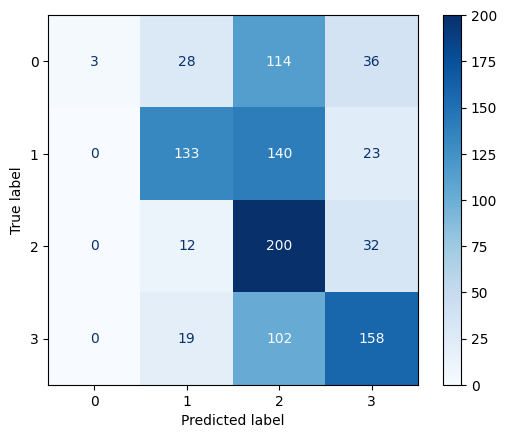

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Label Encoded Values and their Equivalents:


*   Irrelevant: 0
*   Negative: 1
*   Neutral: 2
*   Positive: 3




